# Collaborative Filtering of Movies
## MSDS 7349 - Section 401
## Project 3

[Data Science @ Southern Methodist University](https://datascience.smu.edu/)

# Table of Contents
* [Team Members](#Team-Members)
* [Import Dataset](#Import)
* [Business Understanding](#Business-Understanding)
* [Data Understanding](#Data-Understanding)
* [Data Meaning](#Data-Meaning)
* [Data Visualization](#Data-Visualization)
* [Modeling and Evaluation](#Modeling-and-Evaluation)
* [Train and Adjust Parameters](#Train-and-Adjust-Parameters)
* [Evaluate and Compare](#Evaluate-and-Compare)
* [Visualize Results](#Visualize-Results)
* [Summarize the Ramifications](#Summarize-the-Ramifications)
* [Deployment](#Deployment)
* [Exceptional Work](#Exceptional-Work)
* [References](#References)

# <a name="Team-Members"></a>Team Members
* [Jostein Barry-Straume](https://github.com/josteinstraume)
* [Kevin Cannon](https://github.com/kcannon2)
* [Ernesto Carrera Ruvalcaba](https://github.com/ecarrerasmu)
* [Adam Tschannen](https://github.com/adamtschannen)

# <a name="Import"></a>Import Dataset

In [111]:
%%capture
# Sources:
# https://github.com/eclarson/DataMiningNotebooks/blob/master/13.%20Recommendation%20Systems.ipynb
# Supress output - https://stackoverflow.com/questions/23692950/how-do-you-suppress-output-in-ipython-notebook
# https://acodeforthought.wordpress.com/2016/12/26/building-a-simple-recommender-system-with-movie-lens-data-set/
import graphlab as gl
import matplotlib.pyplot as plt
#import statistics as st
from graphlab import SFrame
import numpy as np
import pandas as pd
%matplotlib inline

filepath = '../data/ml-100k/ratings.csv'
dataCols = ['user_id', 'movie_id', 'rating', 'timestamp']
itemCols = ['movie_id', 'movie_title', 'release_date', 
            'video_release_date', 'IMDB_URL', 'unknown', 
            'action', 'adventure', 'animation', 'childrens',
            'comedy', 'crime', 'documentary', 'drama',
            'fantasy', 'film-noir', 'horror', 'musical',
            'mystery', 'romance', 'sci_fi', 'thriller',
            'war', 'western'          
           ]
userCols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']

data = pd.read_csv('../data/ml-100k/u.data', sep = '\t', names = dataCols, encoding = 'latin-1')
item = pd.read_csv('../data/ml-100k/u.item', sep = '|', names = itemCols, encoding = 'latin-1')
user = pd.read_csv('../data/ml-100k/u.user', sep = '|', names = userCols, encoding = 'latin-1')

dataP = pd.merge(pd.merge(item, data), user)
dataP = dataP.drop('video_release_date', 1)
dataP.to_csv('../data/pandas_dataframe.csv', encoding='latin-1')
dataS = gl.SFrame.read_csv('../data/pandas_dataframe.csv')

# <a name="Business-Understanding"></a>Business Understanding

![xkcd: Machine Learning](../images/machine_learning.png)

* Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?)

> GroupLens is a research lab based out of the University of Minnesota's Department of Computer Science and Engineering. Part of the research lab's focus is in recommender systems. Consequently, GroupLens Research has collected this movie data because they offer a movie recommendation service while providing providing open-source data to the public for free. This dataset was found by our team in a Github Repository compiling publicly available datasets for recommender systems and machine learning. Afterwards, we realized the very same dataset is endorsed in the syllabus as a good dataset to use for project 3. At first glance the data looked clean, offered variable sizing depending on the scope of the project, so we decided to proceed with utilizing GroupLens' data. 

* How will you measure the effectiveness of a good algorithm?

> The effectiveness of a good algorithm produced by this project will be measured with cross validation and evaluated in three ways: Root Mean Squared Error (RMSE), per-user-recall, and per-user-precision.

> The first step in evaluating our algorithm via RMSE will be to calculate the average RMSE of every entry in the dataset using the following equation:

$$RMSE=\sqrt{\frac{1}{N}\sum_{i=1}^N (\hat{y}_i-y_i)^2}$$

> Afterwards, the RMSE for each user in the dataset will be calculated via:

$$\underbrace{RMSE(U)}_{\text{user=U}}=\sqrt{\frac{1}{|U|}\sum_{u\in U} (\hat{y}_u-y_u)^2}$$

> Additionally, the RMSE for each movie in the dataset will be calculated via:

$$\underbrace{RMSE(M)}_{\text{movie=M}}=\sqrt{\frac{1}{|M|}\sum_{m\in M} (\hat{y}_m-y_m)^2}$$

> The per-user-recall will be measured with the following equation:

$$R(k)=\frac{|a \cap p_k|}{|a|} $$

> Wherein $p_k$ is a vector of the $k$ highest ranked recommendations for a given user, and $a$ is the set of all positively ranked items for that given user in the test set.

> The per-user-precision will be measured with the following equation:

$$P(k)=\frac{|a \cap p_k|}{k} $$

> Wherein $p_k$ is a vector of the $k$ recommendations for a given user, and $a$ is the set of all positively ranked items for that given user in the test set.

* Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?

> Potential vehicles in which to validate a given model are A/B testing, Root Mean Squared Error, recall, and precision. A/B testing is not feasible for this project because there is no way to test the model in a live setting. In other words, statistical hypothesis testing via click-rate and response rate cannot be measured in a real-word system because we are not privy to such an application. Fortunately, A/B testing is not the only way to evaluate a recommender system's quality.

> Root Mean Squared Error is one of the most commonly used methods to evaluate a recommender system. RMSE makes sense for the GroupLens movie ratings data because it was specifically collected with recommender systems in mind. In other words, the predicted movie recommendations will be compared to the actual movie recommendations. The GroupLens data even contains its own file of compiled recommendations with which one can carry out comparisons. By measuring general, per-user, and per-movie RMSE, we will be able to discern the quality of a given model on a more granular level. Moreover, visualizing the array of averages produced by per-user and per-movie RMSE will provide a general macro overview of a given model. Additionally, statistical tests will be performed to comparatively evaluate models based on their respect RMSE values.

> Recall evaluation does have some limitations, as not every user is going to rate all movies they watch. Most likely, users will only rate movies for which they have strong positive or negative feelings. However, per-user-recall is still relevant to the stakeholders' needs as it helps to answer the following question of interest: Of all the items rated positively by the user, how many did your recommender find?

> By the same token, the limitations of precision evaluation are the same as those of recall evaluation. Fortunately, per-user-precision still makes sense for validating models for this specific dataset and is still relevant to the stakeholders' needs, because it allows us to answer the following question of interest: Of the k items found by your recommender, how many were rated positively by the user?

> Much like per-user RMSE, statistical hypothesis tests will be used for both recall and precision evaluation to comparatively discern the best performing models produced by this project.

# <a name="Data-Understanding"></a>Data Understanding

## <a name="Data-Meaning"></a>Data Meaning

* Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file

| Variable | Variable Type | Description |
| :------: | :-----------: | :---------- |
| movie_id | int | ID associated with a given movie.<br/> The Movie IDs all contain "at least one rating or tag are included in the dataset"|
| movie_title | str | Title of the given movie. |
| release_date | str | Date that the movie was released. |
| IMDB_URL | str | Hyperlink to the movie's respective IMDB webpage. |
| genres | int | Genre(s) of the given movie selected from the following dummy coded attributes:<br/>Action<br/>Adventure<br/>Animation<br/>Children's<br/>Comedy<br/>Crime<br/>Documentary<br/>Drama<br/>Fantasy<br/>Film-Noir<br/>Horror<br/>Musical<br/>Mystery<br/>Romance<br/>Sci-Fi<br/>Thriller<br/>War<br/>Western<br/>Unknown |
| user_id | int | ID associated with a given user. Users were selected at random for inclusion and IDS have been anonymized.<br/>All selected users had rated at least 20 movies. |
| rating | int | Ratings are made on a zero to 5-star scale, with half-star increments (0.5 stars - 5.0 stars).|
| timestamp | int | Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970. |
| age | int | Age of the given user. |
| gender | str | Gender of the given user: Male or Female. |
| occupation | str | Occupational background of the user |
| zip_code | int | Zip Code that the user lives in |

> As seen below, a call to the shape function verifies the number of observations, as well as attributes within the dataset:

In [112]:
dataP.shape

(100000, 30)

> Moreover, the summary statistics for each non-categorical variable are found below:

In [113]:
dataP.describe()

,movie_id,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,...,mystery,romance,sci_fi,thriller,war,western,user_id,rating,timestamp,age
count,100000.000000,100000.0000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.00000,100000.00000,100000.000000,100000.000000,100000.00000,100000.000000,1.000000e+05,100000.000000
mean,425.530130,0.0001,0.255890,0.137530,0.036050,0.071820,0.298320,0.080550,0.007580,0.398950,...,0.052450,0.194610,0.12730,0.21872,0.093980,0.018540,462.48475,3.529860,8.835289e+08,32.969850
std,330.798356,0.0100,0.436362,0.344408,0.186416,0.258191,0.457523,0.272144,0.086733,0.489685,...,0.222934,0.395902,0.33331,0.41338,0.291802,0.134894,266.61442,1.125674,5.343856e+06,11.562623
min,1.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,1.00000,1.000000,8.747247e+08,7.000000
25%,175.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,254.00000,3.000000,8.794487e+08,24.000000
50%,322.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,447.00000,4.000000,8.828269e+08,30.000000
75%,631.000000,0.0000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,682.00000,4.000000,8.882600e+08,40.000000
max,1682.000000,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,943.00000,5.000000,8.932866e+08,73.000000


> Below, one can see a brief snapshot of how the dataset appears:

In [114]:
dataP.head()

,movie_id,movie_title,release_date,IMDB_URL,unknown,action,adventure,animation,childrens,comedy,...,thriller,war,western,user_id,rating,timestamp,age,gender,occupation,zip_code
0,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,308,4,887736532,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,308,5,887737890,60,M,retired,95076
2,5,Copycat (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,1,0,0,308,4,887739608,60,M,retired,95076
3,7,Twelve Monkeys (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Twelve%20Monk...,0,0,0,0,0,0,...,0,0,0,308,4,887738847,60,M,retired,95076
4,8,Babe (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Babe%20(1995),0,0,0,0,1,1,...,0,0,0,308,5,887736696,60,M,retired,95076


* Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?

In [115]:
dataP.isnull().sum()

movie_id         0
movie_title      0
release_date     9
IMDB_URL        13
unknown          0
action           0
adventure        0
animation        0
childrens        0
comedy           0
crime            0
documentary      0
drama            0
fantasy          0
film-noir        0
horror           0
musical          0
mystery          0
romance          0
sci_fi           0
thriller         0
war              0
western          0
user_id          0
rating           0
timestamp        0
age              0
gender           0
occupation       0
zip_code         0
dtype: int64

In [16]:
# Source:
# https://stackoverflow.com/questions/29530232/how-to-check-if-any-value-is-nan-in-a-pandas-dataframe
dataP.isnull().values.any()

True

> The two above cells of code verify the existence of missing or null values. Specifically, there are 9 null values for movie release date and 13 null values for a given movie's IMDB URL link. However, these attributes are likely to be insignificant with regards to constructing a collaborative filtering recommender system. Therefore, we will leave the values unchanged.

> Now let's check if there exists any duplicate data:

In [116]:
# Source:
# https://stackoverflow.com/questions/9835762/how-do-i-find-the-duplicates-in-a-list-and-create-another-list-with-them
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.duplicated.html
import pandas as pd
dataP.duplicated().sum()

0

> Fortunately, there are no duplicated values within the dataset.

> Now let's check for outliers:

![Rating Boxplot](../images/rating_boxplot.png)

> A quick glance at the dashboard on GraphLab Canvas displays the distribution of values for the rating attribute. The green dot in the above boxplot is representing at least one outlier, since it is outside the lower whisker bound. The general rule-of-thumb is that a datapoint that is 2 standard deviations outside the mean is considered an outlier. If we take this at face value and apply this heuristic blindly, that means that every 1-star rating is considered an outlier in the dataset. Moreover, the histogram below shows 1-star ratings account for over 5,000 observations within the dataset. It is not practical, nor wise, to remove "outliers" in this dataset because it would result in destroying an entire category of ratings.

## <a name="Data-Visualization"></a>Data Visualization

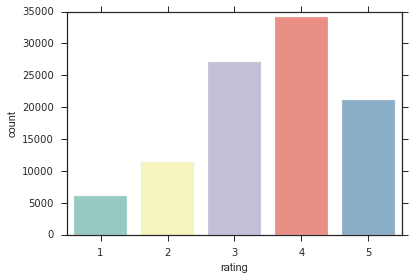

In [117]:
import seaborn as sns
sns.countplot(x="rating", data=dataP, palette="Set3")

> The histogram above displays the distribution of ratings within the dataset. It is visually apparent that the dataset, with regards to rating, is left-tail skewed, and the most frequent rating value is 4. 

## Visualizing Important Attributes

> The command "show" in Turi (executed below) automatically generates a graphical interface to visualize the data in an independent window browser. It is divided into 3 sections: "Summary," "Table," and "Plots". The "Summary" section shows the basic statistics of the variable. For the numeric variables, it creates box-whisker plots, whereas for the categorical variables it generates a horizontal histogram displaying the label of the most frequent items. The "Table" part allows the user to easily navigate through the records of the dataset. Lastly, the component "Plots" enables the analysis of the relationship between 2 variables by generating customized charts. The user can plot the 2 variables using box-whisker, line chart, and a heat map.

In [15]:
dataS.show()

Canvas is accessible via web browser at the URL: http://localhost:57612/index.html
Opening Canvas in default web browser.


##### Looking into the first section "Summary", the description of the most important variables in the dataset is as follows:

> There are 1,657 different titles in the dataset. The top 3 of the movies with the highest number of ratings are the following: Star Wars, Contact, and Fargo.

![Movie title](../images/movie_title.png)

> The number of users in the dataset is 919. 

![user id](../images/user_id.png)

> The users are distributed in 21 distinct occupations. Students and educators are 2 of the most frequent categories.

![occupation](../images/occupation.png)

>Lastly, in the "Plots" section, we display the histogram for the variable gender: 74% of the users are male, whereas 26% of users are female. 

![gender](../images/gender.png)

##### Now, let's take a look at the correlations between the variables. The heat map below exhibits the results:

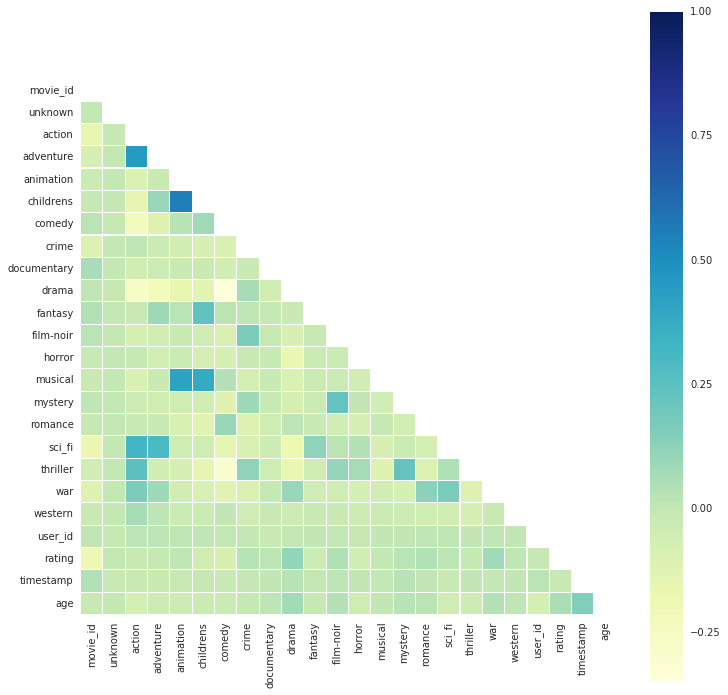

In [118]:
# Correlation heat map matrix
# Source:
# https://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap
corr = dataP.corr(method='pearson')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    plt.figure(figsize=(12, 12))
    heatmap_corr = sns.heatmap(corr, mask=mask, square=True,
                                    linewidths=.1, cmap="YlGnBu")
    plt.savefig('../plots/heatmap_corr.png')

> In the above heat correlation map, there are strong correlations between the action, adventure, and sci-fi movie genres. Similarly, there are strong correlations between the children's, animation, and musical movie genres. Of note, there was no correlation with the video release date to any genre of movie. This spurred us to examine the video_release_date attribute to see what was going on. Upon examination, we found that the video_release_date column of data was entirely empty. Thus it has been removed from the dataset and no longer appears on this correlation heatmap matrix. Interestingly, there is a positive moderate correlation between age of the user and timestamp.

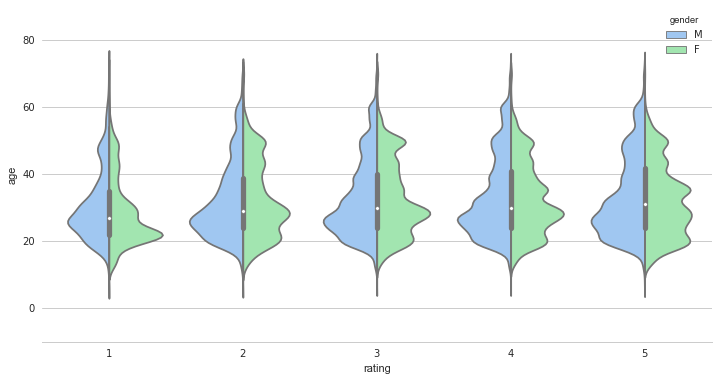

In [119]:
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid", palette="pastel", color_codes=True)
ax = sns.violinplot(x="rating", y="age", hue="gender", data=dataP, split=True)
sns.despine(left=True)

> The violin plots above show the population's age is highly concentrated between the ages of 20 and 40. This age distribution nearly mirrors the traditional 25-54 age demographic traditionally used by markets to mirror peak household spending. This age demographic is an integral part of the marketing world because of growth rates, their value as customers, and relevance as media users, including movies.

In [19]:
dataS.show()

Canvas is accessible via web browser at the URL: http://localhost:52629/index.html
Opening Canvas in default web browser.


# <a name="Modeling-and-Evaluation"></a>Modeling and Evaluation

## <a name="Train-and-Adjust-Parameters"></a>Train and Adjust Parameters

## User-Item Recommendation System

> Now that we have conducted our exploratory data analysis, and visualized important attributes, it is time to build the foundation of our recommender system. Initially, we will start with building a recommender system that does not involve optional Cross-Validation, and for all intents and purposes no regularization parameters. It is important to note that the model selects extremely small input parameters for regularization, and linear_regularization parameters. For example, the model chooses 1e-09 as the regularization factor; from a practical standpoint this is essentially zero. This means that the model is not picking up any latent factors in regards to the item or the user.

In [129]:
import graphlab as gl
model = gl.recommender.create(dataS, user_id="user_id", item_id="movie_title", target="rating")
results = model.recommend(users=None, k=5)
model.save("my_model")

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 97914 observations with 925 users and 1661 items.

Data prepared in: 0.672209s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-09    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-09    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 12239 / 97914 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.66667           | Not Viable                               |

| 1       | 0.416667          | Not Viable                               |

| 2       | 0.104167          | Not Viable                               |

| 3       | 0.0260417         | 1.42135                                  |

| 4       | 0.0130208         | 1.56151                                  |

| 5       | 0.00651042        | 1.92246                                  |

| 6       | 0.00325521        | 2.09452                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0260417         | 1.42135                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 127us        | 2.48441           | 1.12572               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 836.366ms    | 1.64892           | 1.04513               | 0.0260417   |

| 2       | 1.65s        | 1.26374           | 0.970742              | 0.0260417   |

| 3       | 2.49s        | 1.11275           | 0.934048              | 0.0260417   |

| 4       | 3.31s        | 1.02797           | 0.909285              | 0.0260417   |

| 5       | 4.09s        | 0.974595          | 0.891887              | 0.0260417   |

| 6       | 4.86s        | 0.937226          | 0.880708              | 0.0260417   |

| 10      | 7.74s        | 0.851756          | 0.850279              | 0.0260417   |

| 11      | 8.45s        | 0.838604          | 0.844785              | 0.0260417   |

| 15      | 11.17s       | 0.799591          | 0.829441              | 0.0260417   |

| 20      | 14.52s       | 0.767668          | 0.81519               | 0.0260417   |

| 25      | 17.92s       | 0.741015          | 0.804345              | 0.0260417   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.729921

Final training RMSE: 0.795719

In [130]:
results # the recommendation output

user_id,movie_title,score,rank
308,"Princess Bride, The(1987) ...",4.32574369894,1
308,Star Trek: First Contact(1996) ...,4.16742413627,2
308,Swingers (1996),4.12453061478,3
308,Mission: Impossible(1996) ...,4.10560810702,4
308,"People vs. Larry Flynt,The (1996) ...",4.095754364,5
287,Good Will Hunting (1997),4.58296971159,1
287,"Game, The (1997)",4.4284829306,2
287,"Fish Called Wanda, A(1988) ...",4.39201697843,3
287,Fly Away Home (1996),4.35524051027,4
287,"Killing Fields, The(1984) ...",4.3153603463,5


> Above one can see the top five recommended movies for a couple of the users in the dataset. User 308 appears to have a diverse range of genre interests including comedy, sci-fi, action, and drama/biography. In contrast, the top five recommended movies to user 287 are all dramas and/or crime films. We think that finding some latent patterns among user rating trends would improve the precision and recall of the recommender system.

> Using the training set we created earlier, this baseline recommender system has a Root Mean Squared Error (RMSE) value of 0.795719. The meaning of this value is that the recommender system is able to predict the rating of a given movie within approximately 0.80 stars of the actual rating. Next we will build an item by item recommender system.

## Item-Item Recommendation System

> Now that we have constructed a baseline user per item recommender system, let's see how a general item to item recommender system would perform. The item to item recommendation system is suggesting movies based on other movies and not based on the user. This is essentially recommending movies based on “if you watched that movie you will likely want to watch this movie.”

In [23]:
item_item = gl.recommender.item_similarity_recommender.create(dataS, 
                                  user_id="user_id", 
                                  item_id="movie_title", 
                                  target="rating",
                                  only_top_k=3,
                                  similarity_type="cosine")

results = item_item.get_similar_items(k=3)
results.head()

Recsys training: model = item_similarity

Warning: Ignoring columns X1, movie_id, release_date, video_release_date, IMDB_URL, unknown, action, adventure, animation, childrens, comedy, crime, documentary, drama, fantasy, film-noir, horror, musical, mystery, romance, sci_fi, thriller, war, western, timestamp, age, gender, occupation, zip_code;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 97914 observations with 925 users and 1661 items.

Data prepared in: 0.123017s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 2.572ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 10.502ms                            | 0.75             | 13              |

| 57.532ms                            | 100              | 1661            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.064661s

movie_title,similar,score,rank
Toy Story (1995),Star Wars (1977),0.731784462929,1
Toy Story (1995),Return of the Jedi (1983),0.697239160538,2
Toy Story (1995),Independence Day (ID4)(1996) ...,0.687915802002,3
Get Shorty (1995),Pulp Fiction (1994),0.648687839508,1
Get Shorty (1995),Back to the Future (1985),0.631140470505,2
Get Shorty (1995),Raiders of the Lost Ark(1981) ...,0.630040228367,3
Copycat (1995),Cape Fear (1991),0.540185034275,1
Copycat (1995),Outbreak (1995),0.464888572693,2
Copycat (1995),"Nightmare on Elm Street,A (1984) ...",0.457200467587,3
Twelve Monkeys (1995),Fargo (1996),0.689777255058,1


> The above output table reflects the top three suggested movies for the following films: Toy Story, Get Shorty, and Copycat. At first glance, recommending Independence Day based on Toy Story seems odd. Toy Story is an animated children's movie, while Independence Day is about an apocalyptic alien encounter. Perhaps splitting the dataset into training and testing sets could improve the suggested movies in an item to item recommender system.

> The train and test sets will be split into 80% and 20% of the original dataset, respectively. Furthermore, the maximum number of users to construct the test set will be capped at 100. Additionally, the measure of similarity between movies will be performed via cosine similarity.

In [24]:
train, test = gl.recommender.util.random_split_by_user(dataS,
                                                    user_id="user_id", item_id="movie_id",
                                                    max_num_users=100, item_test_proportion=0.2, random_seed=1)

In [48]:
from IPython.display import display
from IPython.display import Image

gl.canvas.set_target('ipynb')


item_item = gl.recommender.item_similarity_recommender.create(train, 
                                  user_id="user_id", 
                                  item_id="movie_id", 
                                  target="rating",
                                  only_top_k=5,
                                  similarity_type="cosine")

rmse_results_item = item_item.evaluate(test)

Recsys training: model = item_similarity

Warning: Ignoring columns X1, movie_title, release_date, video_release_date, IMDB_URL, unknown, action, adventure, animation, childrens, comedy, crime, documentary, drama, fantasy, film-noir, horror, musical, mystery, romance, sci_fi, thriller, war, western, timestamp, age, gender, occupation, zip_code;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 95765 observations with 925 users and 1677 items.

Data prepared in: 0.09209s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.882ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 9.458ms                             | 0                | 2               |

| 64.047ms                            | 100              | 1677            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.071922s


Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.49      | 0.0349076130698 |
|   2    |      0.53      | 0.0824669301669 |
|   3    |      0.49      |  0.111536627534 |
|   4    |     0.4525     |  0.136823771039 |
|   5    |     0.416      |  0.147925008089 |
|   6    |     0.405      |  0.171381859988 |
|   7    |      0.38      |  0.18146161008  |
|   8    |    0.36625     |  0.195038959544 |
|   9    | 0.353333333333 |  0.208695957778 |
|   10   |     0.341      |  0.221058194103 |
+--------+----------------+-----------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 3.5936694035490335)

Per User RMSE (best)
+---------+-------+---------------+
| user_id | count |      rmse     |
+---------+-------+---------------+
|   724   |   19  | 2.42521383674 |
+---------+-------+---------------+
[1 rows x 3 columns]


Per User RMSE (w

> The resulting model, at the cutoff = 10 level, has a mean precision of 34.1% and a mean recall of 22.1%. This would appear to be a phenomenal model until one observes the overall RMSE. The model's overall RMSE is 3.59. In other words, the model can predict the rating of a given movie to within 3.59 stars. However, the rating system itself only has a range of 5. Essentially, this means that the model is unable to predict the rating of a given movie.

In [49]:
print rmse_results_item.viewkeys()

dict_keys(['rmse_by_user', 'precision_recall_overall', 'rmse_by_item', 'precision_recall_by_user', 'rmse_overall'])


In [50]:
rmse_results_item['rmse_by_user']

user_id,count,rmse
786,25,3.71869638022
516,5,3.68582684054
465,12,3.75839468645
376,7,3.88064945113
193,26,3.35525918877
810,5,4.25467312815
336,24,3.40201023193
176,7,3.79166489805
407,48,3.64627422479
214,19,3.8486400219


> In comparison to the overall RMSE, the RMSE per user values do not fair any better with this model. Note that among the users selected in this output, the lowest corresponding RMSE value is approximately 3.36. By the same token, the highest RMSE per user listed in the above table is approximately 4.25. In both the best case and worst case scenarios, the model is never able to practically rate a given movie.

> To gain a better understanding about RMSE by user values, let's plot the RMSE by user values for every user who has rated more than fifty films.

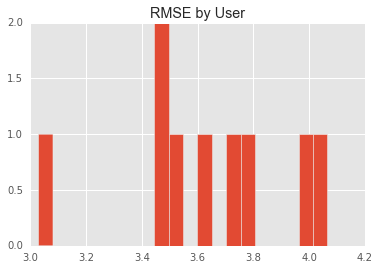

In [51]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

rmsevals = rmse_results_item['rmse_by_user']['rmse']
rmsevals = rmsevals[rmse_results_item['rmse_by_user']['count']>50]

plt.hist(rmsevals,bins=20)
plt.title('RMSE by User')
plt.show()

> The users that have at least 50 reviews appear to result in lower RMSE by user values. Since there are more observations for the model to use, it would make sense that predicting the ratings is done more efficiently with users who are moderately active in rating the films that they watch.

> After visually examining RMSE by user values, let's query the precision and recall for the first user just to see what is going on under the hood.

In [52]:
rmse_results_item['precision_recall_by_user']

user_id,cutoff,precision,recall,count
1,1,1.0,0.0188679245283,53
1,2,1.0,0.0377358490566,53
1,3,0.666666666667,0.0377358490566,53
1,4,0.75,0.0566037735849,53
1,5,0.8,0.0754716981132,53
1,6,0.666666666667,0.0754716981132,53
1,7,0.714285714286,0.0943396226415,53
1,8,0.625,0.0943396226415,53
1,9,0.555555555556,0.0943396226415,53
1,10,0.5,0.0943396226415,53


> Per-user-recall, simply stated, means "of all the items rated positively by the user, how many did your recommender find?" Therefore, as the cutoff value increases for the number of movies, the recommender system has an increased chance of finding positively rated movies from the user. Similarly, per-user-precision means "of the items found by your recommender, how many were rated positively by the user?"

> Take, for example, the second row of the above table. In this situation, the model is recommending 2 films (cutoff = 2) based on the user's ratings. A precision of 1.0 means that both of the 2 movies were relevant. A recall of 0.038 means that both of the movies were found among the 53 movies rated by user 1.

> The recall will increase as the model finds more movies. Put differently, it is not guaranteed to increase, but only increases as correct selections are made. Based on how recall is calculated, it is important to note that recall will never decrease as one adds movies to the original recommendation set. As we keep on adding more movies, the recall will increase. Theoretically, after cutoff is greater than the number of rated movies (count), then precision will decrease. In other words, the user by item recommender system cannot accurately suggest a movie that is not rated by the user.

> As an attempt to increase precision and recall, while at the same time decreasing RMSE, we will now incorporate cross validation into the model.

## Cross Validated Collaborative Filtering

> By condensing the dimensionality of the user-item matrix, we are attempting to capture the generalizations that are contained within the data. In other words, dimension reduction via factorization will attempt to capture "latent patterns" that occur between users and the movies they have rated.

In [46]:
rec1 = gl.recommender.ranking_factorization_recommender.create(train, 
                                  user_id="user_id", 
                                  item_id="movie_id", 
                                  target="rating")

rmse_results = rec1.evaluate(test)

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 95765 observations with 925 users and 1677 items.

Data prepared in: 0.492385s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-09    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-09    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 11970 / 95765 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.6129            | Not Viable                               |

| 1       | 0.403226          | Not Viable                               |

| 2       | 0.100806          | 0.278882                                 |

| 3       | 0.0504032         | 0.457041                                 |

| 4       | 0.0252016         | 1.05447                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.100806          | 0.278882                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 98us         | 2.48464           | 1.12555               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 902.296ms    | DIVERGED          | DIVERGED              | 0.100806    |

| RESET   | 1.18s        | 2.48378           | 1.12557               |             |

| 1       | 1.99s        | 1.5097            | 1.06353               | 0.0504032   |

| 2       | 2.69s        | 0.986529          | 0.906702              | 0.0504032   |

| 3       | 3.35s        | 0.820153          | 0.843043              | 0.0504032   |

| 4       | 4.01s        | 0.732519          | 0.804587              | 0.0504032   |

| 5       | 4.66s        | 0.676156          | 0.777683              | 0.0504032   |

| 6       | 5.30s        | 0.637209          | 0.757814              | 0.0504032   |

| 9       | 7.09s        | 0.563268          | 0.717457              | 0.0504032   |

| 11      | 8.26s        | 0.533201          | 0.700181              | 0.0504032   |

| 14      | 9.99s        | 0.500192          | 0.680174              | 0.0504032   |

| 19      | 12.87s       | 0.462969          | 0.65641               | 0.0504032   |

| 24      | 15.99s       | 0.438509          | 0.640055              | 0.0504032   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.415669

Final training RMSE: 0.621579


Precision and recall summary statistics by cutoff
+--------+----------------+------------------+
| cutoff | mean_precision |   mean_recall    |
+--------+----------------+------------------+
|   1    |      0.2       | 0.00920171132449 |
|   2    |     0.195      | 0.0180245014757  |
|   3    |      0.18      | 0.0235739925242  |
|   4    |     0.1625     | 0.0281352577262  |
|   5    |     0.158      | 0.0342182068187  |
|   6    | 0.151666666667 | 0.0398803773343  |
|   7    | 0.142857142857 |  0.044368675411  |
|   8    |    0.13875     | 0.0530120799204  |
|   9    | 0.133333333333 | 0.0585433579918  |
|   10   |     0.132      | 0.0631493975212  |
+--------+----------------+------------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 1.0095544223807171)

Per User RMSE (best)
+---------+-------+----------------+
| user_id | count |      rmse      |
+---------+-------+----------------+
|   772   |   3   | 0.292320739323 |
+---------+-------+----------------+
[1 rows x 3 columns]

In [47]:
import graphlab.aggregate as agg
rmse_results['precision_recall_by_user'].groupby('cutoff',[agg.AVG('precision'),agg.STD('precision'),agg.AVG('recall'),agg.STD('recall')])

cutoff,Avg of precision,Stdv of precision,Avg of recall,Stdv of recall
16,0.125,0.150779226023,0.0963136636224,0.108840621087
10,0.132,0.166060230037,0.0631493975212,0.0880872590733
36,0.0977777777778,0.114158218125,0.155950873908,0.136178160666
26,0.110384615385,0.131969043349,0.1275552003,0.126388148216
41,0.0921951219512,0.105165799242,0.16906267494,0.138414268604
3,0.18,0.284487843911,0.0235739925242,0.0438055431648
1,0.2,0.4,0.00920171132449,0.028334732703
6,0.151666666667,0.208293329493,0.0398803773343,0.0613258552086
11,0.131818181818,0.164831494222,0.072915317771,0.0996242749411
2,0.195,0.307367857786,0.0180245014757,0.0359023962553


> After taking a look at the aggregation, we find a cutoff value of 16 provides the best combination of precision and recall for our model. Basically, if the recommender system recommends 16 movies to every user, the system will accurately recommend the correct movie about 13% of the time with a standard deviation of 0.14. Specifically, this cutoff is the best because it produces the highest average precision relative to the standard deviation. In contrast, when we see a single movie recommended as the cutoff, the model has an average precision of 23% but a very high standard deviation of 0.42. The standard deviation for the correct recommendation is so high because if only 1 movie is recommended, the recommendation system can only be either 100% correct or 0% correct.

> Now, let's adjust the parameters in our cross-validation model to see if the resulting user-item recommender system can perform better. We will run the model again, but this time invoking three optional parameters within the recommender function.

> First, num_factors input parameter will be set to the value of 16. By increasing the num_factor value, we are increasing the importance of these latency factors. In other words, we are amplifying the user's biases to capitalize on general trends within the rating system. Simply put, "if a user tends to love romance movies and hate action movies, the factor terms attempt to capture that, causing the model to predict lower scores for action movies and higher scores for romance movies" [[Source]](https://turi.com/products/create/docs/generated/graphlab.recommender.ranking_factorization_recommender.RankingFactorizationRecommender.html).

> Secondly, the regularization input parameter will be set to the value of 1e-02. Invoking the regularization parameter will hopefully result in a more accurate model. With this outcome in mind, the linear_regularization input parameter will be set to 1e-3 for similar reasons. These regularization terms are influential and help our model use underlying patterns found in the data.

> Additionally, introducing regularization terms into the model will avoid over-fitting. As a result, a more accurate and precise model should be created.

In [32]:
rec1 = gl.recommender.ranking_factorization_recommender.create(train, 
                                  user_id="user_id", 
                                  item_id="movie_id", 
                                  target="rating",
                                  num_factors=16,                 # override the default value
                                  regularization=1e-02,           # override the default value
                                  linear_regularization = 1e-3)   # override the default value

rmse_results_regularized = rec1.evaluate(test)

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 95765 observations with 925 users and 1677 items.

Data prepared in: 0.450685s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 11970 / 95765 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0769116         | 1.91537                                  |

| 1       | 0.0384558         | 1.92132                                  |

| 2       | 0.0192279         | 2.01823                                  |

| 3       | 0.00961395        | 2.08392                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0769116         | 1.91537                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 99us         | 2.48463           | 1.12554               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 493.995ms    | 2.20596           | 1.08718               | 0.0769116   |

| 2       | 966.503ms    | 2.04155           | 1.07039               | 0.0769116   |

| 3       | 1.42s        | 1.95616           | 1.04696               | 0.0769116   |

| 4       | 3.40s        | 1.93159           | 1.03801               | 0.0769116   |

| 5       | 3.87s        | 1.92753           | 1.03404               | 0.0769116   |

| 6       | 4.36s        | 1.92401           | 1.0291                | 0.0769116   |

| 10      | 6.23s        | 1.92358           | 1.02423               | 0.0769116   |

| 11      | 6.71s        | 1.92369           | 1.02317               | 0.0769116   |

| 15      | 8.87s        | 1.9217            | 1.02288               | 0.0769116   |

| 20      | 11.63s       | 1.92242           | 1.02242               | 0.0769116   |

| 25      | 14.09s       | 1.92061           | 1.02145               | 0.0769116   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.9487

Final training RMSE: 1.01534


Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.41      | 0.0245176382872 |
|   2    |     0.295      | 0.0323091534557 |
|   3    | 0.256666666667 | 0.0432480131879 |
|   4    |     0.2325     | 0.0480254797209 |
|   5    |     0.214      | 0.0538471854784 |
|   6    |     0.195      | 0.0568326121534 |
|   7    | 0.195714285714 | 0.0665445114345 |
|   8    |    0.19125     |  0.073653840332 |
|   9    |      0.19      |  0.081337962443 |
|   10   |     0.184      | 0.0857256295173 |
+--------+----------------+-----------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 1.0263688824394601)

Per User RMSE (best)
+---------+-------+----------------+
| user_id | count |      rmse      |
+---------+-------+----------------+
|   516   |   5   | 0.245116586351 |
+---------+-------+----------------+
[1 rows x 3 columns]


Per User RM

In [33]:
import graphlab.aggregate as agg
rmse_results_regularized['precision_recall_by_user'].groupby('cutoff',[agg.AVG('precision'),agg.STD('precision'),agg.AVG('recall'),agg.STD('recall')])

cutoff,Avg of precision,Stdv of precision,Avg of recall,Stdv of recall
16,0.168125,0.18639151503,0.125730281467,0.116557941542
10,0.184,0.204313484626,0.0857256295173,0.0859471683947
36,0.133333333333,0.13955396319,0.232180700065,0.152707956537
26,0.15,0.157504578688,0.196073941529,0.138612010238
41,0.128780487805,0.130940859268,0.266387717821,0.161786112443
3,0.256666666667,0.301311946144,0.0432480131879,0.0687109385191
1,0.41,0.491833305094,0.0245176382872,0.0442796602714
6,0.195,0.224913563644,0.0568326121534,0.0717021520492
11,0.179090909091,0.205082124248,0.0903645379645,0.0918493980565
2,0.295,0.347095087836,0.0323091534557,0.0493426833448


> Comparing the results to those we produced prior to introducing regularization terms, our new model has a higher average precision as well as a lower standard deviation of precision. In addition, the average recall is higher with a lower standard deviation. Based on these metrics, we have created a better performing model with the addition of these new parameters.

* RMSE before regularization parameters: 0.978076840491603
* RMSE with regularization parameters: 1.0353293256561886

> It is important to note that the Root Mean Squared Error (RMSE) has increased by introducing regularization parameters into the model. However, RMSE is only increasing by approximately 0.057. As a result, we are trading a little higher RMSE in exchange for receiving higher precision, higher recall, and lower variance, respectively.

## <a name="Evaluate-and-Compare"></a>Evaluate and Compare

In [36]:
comparison = gl.recommender.util.compare_models(test, [item_item, rec1])

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.49      | 0.0349076130698 |
|   2    |      0.53      | 0.0824669301669 |
|   3    |      0.49      |  0.111536627534 |
|   4    |     0.4525     |  0.136823771039 |
|   5    |     0.416      |  0.147925008089 |
|   6    |     0.405      |  0.171381859988 |
|   7    |      0.38      |  0.18146161008  |
|   8    |     0.365      |  0.194795057105 |
|   9    | 0.353333333333 |  0.208695957778 |
|   10   |     0.342      |  0.222486765532 |
+--------+----------------+-----------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 3.5937395449421956)

Per User RMSE (best)
+---------+-------+---------------+
| user_id | count |      rmse     |
+---------+-------+---------------+
|   724   |   19  | 2.42521383674 |
+---------+-------+---------------+
[1 rows x 3

> In the comparison in the section above, our item_item model has a higher mean precision and mean recall than our cross validation model. However, the RMSE of our cross validation model is 1.026, which is less than a third of the item_item recommender's RMSE of 3.59. This difference means the item_item model is better at correctly recommending movies effectively, but not as good as correctly predicting the exact rating the user will rate the particular movie. Based on this fact, the item_item model is the better model for our purposes because we value the ability to recommend a movie that the user will like over trying to predict what the rating is the user will give that specific movie.

In [40]:
gl.show_comparison(comparisonstruct,[item_item, rec1])

In [54]:
import graphlab.aggregate as agg
rmse_results_item['precision_recall_by_user'].groupby('cutoff',[agg.AVG('precision'),agg.STD('precision'),agg.AVG('recall'),agg.STD('recall')])

cutoff,Avg of precision,Stdv of precision,Avg of recall,Stdv of recall
16,0.28875,0.206113591255,0.290032987602,0.19147232387
10,0.341,0.247424736031,0.221058194103,0.180108732258
36,0.202777777778,0.162849813412,0.421973498085,0.206924941335
26,0.235384615385,0.182299577878,0.364865701381,0.203286475144
41,0.189024390244,0.15345999562,0.440353465402,0.210866257067
3,0.49,0.363486206371,0.111536627534,0.134386632663
1,0.49,0.499899989998,0.0349076130698,0.0690269774798
6,0.405,0.286991095487,0.171381859988,0.171263755684
11,0.328181818182,0.244913545212,0.230191649728,0.184263259535
2,0.53,0.398873413504,0.0824669301669,0.107971471739


In [55]:
rmse_results_regularized['precision_recall_by_user'].groupby('cutoff',[agg.AVG('precision'),agg.STD('precision'),agg.AVG('recall'),agg.STD('recall')])

cutoff,Avg of precision,Stdv of precision,Avg of recall,Stdv of recall
16,0.168125,0.18639151503,0.125730281467,0.116557941542
10,0.184,0.204313484626,0.0857256295173,0.0859471683947
36,0.133333333333,0.13955396319,0.232180700065,0.152707956537
26,0.15,0.157504578688,0.196073941529,0.138612010238
41,0.128780487805,0.130940859268,0.266387717821,0.161786112443
3,0.256666666667,0.301311946144,0.0432480131879,0.0687109385191
1,0.41,0.491833305094,0.0245176382872,0.0442796602714
6,0.195,0.224913563644,0.0568326121534,0.0717021520492
11,0.179090909091,0.205082124248,0.0903645379645,0.0918493980565
2,0.295,0.347095087836,0.0323091534557,0.0493426833448


> In the above tables, we can see the item_item model has a higher average precision and average recall than our regularized model. However, the item_item model has a higher standard deviation as well, meaning it is more volatile even though its average may be more accurate. The regularized user_item model is more consistent in its recommendations, on the other hand, at the cost of a lower precision and recall. In contrast, the item_item model is more accurate overall, but the accuracy comes at the cost of its consistency with regards to which movies are recommended.

> A model that minimizes both biases and variance is ideal. However, in a real-world setting, we often have to make compromises. Perhaps in a deployment scenario, Netflix would prefer the model that has more consistency, while Amazon is fine with recommending a large span of movies.

> Now we will perform a grid search on our user to item model to find the optimal parameters to increase precision and recall while simultaneously decreasing RMSE.

In [61]:
%%capture
params = {'user_id': 'user_id', 
          'item_id': 'movie_id', 
          'target': 'rating',
          'num_factors': [8, 12, 16, 24, 32], 
          'regularization':[0.001] ,
          'linear_regularization': [0.001]}

job = gl.model_parameter_search.create( (train,test),
        gl.recommender.ranking_factorization_recommender.create,
        params,
        max_models=10,
        environment=None)

In [62]:
job.get_status()

{'Canceled': 0, 'Completed': 0, 'Failed': 0, 'Pending': 0, 'Running': 10}

In [63]:
job_result = job.get_results()

job_result.head()

model_id,item_id,linear_regularization,max_iterations,num_factors,num_sampled_negative_examples ...,ranking_regularization
9,movie_id,0.001,50,24,4,0.5
8,movie_id,0.001,25,12,4,0.25
1,movie_id,0.001,50,12,4,0.25
0,movie_id,0.001,50,16,8,0.25
3,movie_id,0.001,25,24,8,0.5
2,movie_id,0.001,50,12,4,0.25
5,movie_id,0.001,25,8,4,0.1
4,movie_id,0.001,25,8,8,0.25
7,movie_id,0.001,25,12,8,0.25
6,movie_id,0.001,25,16,4,0.25


In [64]:
models = job.get_models()
models

[Class                            : RankingFactorizationRecommender
 
 Schema
 ------
 User ID                          : user_id
 Item ID                          : movie_id
 Target                           : rating
 Additional observation features  : 29
 User side features               : []
 Item side features               : []
 
 Statistics
 ----------
 Number of observations           : 95765
 Number of users                  : 925
 Number of items                  : 1677
 
 Training summary
 ----------------
 Training time                    : 38.644
 
 Model Parameters
 ----------------
 Model class                      : RankingFactorizationRecommender
 num_factors                      : 16
 binary_target                    : 0
 side_data_factorization          : 1
 solver                           : auto
 nmf                              : 0
 max_iterations                   : 50
 
 Regularization Settings
 -----------------------
 regularization                   : 0.001
 r

In [67]:
comparisonstruct = gl.compare(test,models)
gl.show_comparison(comparisonstruct,models)

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.24      | 0.0111971017177 |
|   2    |      0.21      | 0.0199891634809 |
|   3    | 0.196666666667 | 0.0293001129809 |
|   4    |     0.195      | 0.0394266963327 |
|   5    |      0.18      | 0.0431331104633 |
|   6    | 0.173333333333 |  0.050768112584 |
|   7    |      0.17      |  0.05551855396  |
|   8    |     0.1675     |  0.069145546105 |
|   9    |      0.17      |  0.07990433749  |
|   10   |     0.164      | 0.0832534099984 |
+--------+----------------+-----------------+
[10 rows x 3 columns]

PROGRESS: Evaluate model M1

Precision and recall summary statistics by cutoff
+--------+----------------+------------------+
| cutoff | mean_precision |   mean_recall    |
+--------+----------------+------------------+
|   1    |      0.23      | 0.0094

> In the above grid search, results indicate that model 6 is our best model with parameters of num_factor = 8, regularization  = 1e-03, and linear_regularization = 1e-3. For reference sake, the final model is show below:

In [68]:
final_model = gl.recommender.ranking_factorization_recommender.create(train, 
                                  user_id="user_id", 
                                  item_id="movie_id", 
                                  target="rating",
                                  num_factors=8,                 # override the default value
                                  regularization=1e-03,           # override the default value
                                  linear_regularization = 1e-3)   # override the default value

final_rmse = final_model.evaluate(test)

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 95765 observations with 925 users and 1677 items.

Data prepared in: 0.525534s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 11970 / 95765 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.769116          | 2.23706                                  |

| 1       | 0.384558          | 2.06461                                  |

| 2       | 0.192279          | 2.00553                                  |

| 3       | 0.0961395         | 1.85972                                  |

| 4       | 0.0480697         | 1.77566                                  |

| 5       | 0.0240349         | 1.81512                                  |

| 6       | 0.0120174         | 1.88469                                  |

| 7       | 0.00600872        | 1.96316                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0480697         | 1.77566                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 121us        | 2.48468           | 1.12556               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 244.711ms    | 1.98026           | 1.06681               | 0.0480697   |

| 2       | 495.011ms    | 2.00395           | 1.04409               | 0.0480697   |

| 3       | 741.877ms    | 1.89754           | 0.997979              | 0.0480697   |

| 4       | 997.938ms    | 1.84775           | 0.9724                | 0.0480697   |

| 5       | 1.24s        | 1.82384           | 0.956761              | 0.0480697   |

| 6       | 1.49s        | 1.81288           | 0.945897              | 0.0480697   |

| 10      | 2.46s        | 1.79033           | 0.922073              | 0.0480697   |

| 11      | 2.70s        | 1.78694           | 0.919854              | 0.0480697   |

| 15      | 3.72s        | 1.77639           | 0.910802              | 0.0480697   |

| 20      | 4.94s        | 1.76255           | 0.905177              | 0.0480697   |

| 25      | 6.22s        | 1.75064           | 0.90157               | 0.0480697   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.7629

Final training RMSE: 0.897053


Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.27      | 0.0167398421015 |
|   2    |      0.27      |  0.033438833722 |
|   3    | 0.236666666667 | 0.0458637149225 |
|   4    |     0.2175     | 0.0540661319407 |
|   5    |     0.222      | 0.0667239593019 |
|   6    |     0.205      | 0.0714670597699 |
|   7    | 0.195714285714 |  0.077820004434 |
|   8    |     0.1925     | 0.0912196620676 |
|   9    | 0.184444444444 | 0.0949948237662 |
|   10   |      0.18      |  0.103585521801 |
+--------+----------------+-----------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 0.9481035455631394)

Per User RMSE (best)
+---------+-------+----------------+
| user_id | count |      rmse      |
+---------+-------+----------------+
|    34   |   1   | 0.106109717829 |
+---------+-------+----------------+
[1 rows x 3 columns]


Per User RM

## <a name="Visualize-Results"></a>Visualize Results

> The plot below reflects the precision and recall of each of the ten constructed models. One can visually see how different cutoff values impact both the precision and recall. In general, most of the models have decreasing precision as recall increases.

![Recall and Precision](../images/line_recall_precision.png)

> The chart below displays the performance of the final model that was selected. As we increase the cutoff value, the recall increases whereas the precision decreases, which is consistent with the general trends of the ten models. At the cutoff value of 10, we obtain an accuracy of 10%, which is part of our goals of this model development.

![Mean Precision and Recall](../images/precision_recall.png)

## <a name="Summarize-the-Ramifications"></a>Summarize the Ramifications


>Our project was based on a data set we found on a Github Repository compiling publicly available datasets for recommender systems and machine learning projects. Our goal was to be able to build a recommendation system which could accurately recommend a movie to a user 10% of the time. By using a grid search on our user to item model using parameters to map out latent factors, we were able to achieve this goal by developing a model which had an accuracy of over 10%. Furthermore, our RMSE dropped to below 1, meaning our model was relatively consistent in addition to the accuracy.

$$RMSE=\sqrt{\frac{1}{N}\sum_{i=1}^N (\hat{y}_i-y_i)^2}$$

> The Overall RMSE of the final model is approximately 1 (actual value is 0.9481). The ramification of this resulting RMSE value is that the model predicts the rating of a given movie to within 1 star of the actual rating. Unfortunately, with only 5 potential rating options, this performance does not appear to be stellar. If, however, the rating system was on a scale from 1 to 20, an RMSE value of approximately 1 would be great. As an example, this model might meet the criteria for Netflix circa 2005, where the company's RMSE was at 0.95. Unfortunately, this model would not meet the criteria for Netflix today, as their RMSE has improved.  The completion of the 2006 Netflix Kaggle completion decreased their recommender system's RMSE to below 0.87.

$$R(k)=\frac{|a \cap p_k|}{|a|} $$

> In general, precision is the total number of recommended items that are relevant divided by the total number of items. The final model has a precision of 18%. Applying this general concept of precision to a movie recommender system, 18% of all movies recommended to a given user by our system are considered relevant to that said user.

$$P(k)=\frac{|a \cap p_k|}{k} $$

> By the same token, recall is the total number of recommended items that are relevant divided by the total number of relevant items. The final model has a recall of approximately 10.4%. Applying this general concept of recall to a movie recommender system, 10.4% of the total number of relevant movies recommended to a given user appear in the top 3 recommendation results (since k value in the models is 3).

> The final model is not without its limitations. Ultimately, we cannot know how the final model would perform in a real world situation without actually applying it and measuring its success via implicit user rating and A/B testing. The precision and recall are only useful depending on how many movies the user has rated. Meaning, if we recommend a movie the user actually does like, but that user has not rated any movies, we will have a precision and recall of 0 even though it was a relevant recommendation.

> One of the more compelling findings for our project relates to latent factors. When we set up parameters to find latent factors, the precision and recall decreased, but the standard deviation of the model decreased as well, making it more consistent. Intuitively, one would think if the model had additional information to use to recommend a movie, such as user patterns for ratings and movie rating patterns,  it would increase the accuracy and recall and not just lower the standard deviation. Keeping this notion in mind, we would think over time, this model would constantly learn and improve with more information, subsequently creating more accurate latent factors which would incrementally increase the accuracy and recall.

> Some of the general ramifications of using a recommender system include popular movies staying popular. For instance, if one movie has a lot of five star ratings, it is more likely to be recommended than a movie with zero star ratings.

> This rating gap leads us to our next ramification -  new movies will not be recommended at all.  If a new movie gets added to the list without any ratings, it will not likely be recommended based on the rating system. Because of this downfall, the likelihood of a niche movie to stay niche movie and a popular movie to stay popular over time will likely remain the same.

> Depending on the needs of our clients and/or stakeholders, this model may or may not meet their criteria. For example, as previously mentioned, a company might be more risk adverse and prefer a model that is more consistent, even if it comes at the cost of overall accuracy. Tomáš Řehořek of Medium.com touches on this topic very succinctly in his December 2016 article, wherein he states:

> "In some cases... it is a fair strategy to recommend only the globally most popular items (a.k.a. bestsellers) to achieve reasonable recall... Do you wish you users to keep discovering new and new content to stay loyal? Then you might want to recommend as many different items as possible." [[Source]](https://medium.com/recombee-blog/evaluating-recommender-systems-choosing-the-best-one-for-your-business-c688ab781a35)

# <a name="Deployment"></a>Deployment

* Did you achieve your goals? If not, can you reign in the utility of your modeling?

> In the beginning of this project we stated that our goal was to achieve an accuracy of at least 10%. Although we had hope the RMSE value would be lower, both the average precision and recall met this 10% threshold. As such, we consider the project to be a success in that we met the goals we laid out as groundwork.

* How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)?

> A model that minimizes both biases and variance is ideal. However, in a real-world setting, we often have to make compromises. Perhaps in a deployment scenario, Netflix would prefer the model that has more consistency, while Amazon would be fine with recommending a large spectrum of movies. Such differences could be tested for user preferences via A/B testing in a live-setting. However, we currently are not in that situation, so we can only hypothesize about the A/B testing at the moment.

> One limiting factor of the model is that the location data is based on U.S. zip codes. While the recommendations could be extrapolated out and used in other countries, the ratings would not account for international preferences and tastes. Without additional rating data from other countries, the recommendations may not be as meaningful internationally.

* How would your deploy your model for interested parties?

> The logistics of deploying our model for an interested party really depends on that companies technology stack and security requirements. If a company was agreeable to a stand-alone platform, an interactive Python dashboard could be built to give recommendations based on the selected input parameters of the user. Plotly is one such tool that could be used to accomplish such a thing: https://plot.ly/python/dashboard/. However, if the client needed to incorporate the recommender system into their existing service or application natively, then the deployment logistics would center around their product and vary based on the given client's ecosystem and technological stack.

* What other data should be collected?

> Implicit feedback is not included in the data or included in the model. The current model uses explicit feedback - a direct movie rating - to determine the recommendations. However, including implicit feedback could allow the model to better tailor recommendations to meet user preferences. Implicit feedback can be collected passively from the user. Implicit feedback could include such data as how long a movie was watched, how many times a movie was watched, and the elapsed time between the recommendation being made and the user selecting the movie to watch. This additional data could provide more factors on which to base recommendations and potentially increase the accuracy.

> Additionally, A/B testing could be utilized to measure the dynamic nature of users to discern which models perform better in a live-setting environment.

> One additional piece of data that could be collected would be user satisfaction post-recommendation. While we can be sure the recommendations are accurate based on the precision and recall metrics, the rating system ends there. No feedback is provided on how valuable the recommendation was to the user. A user could rate his or her satisfaction with the recommendation after he or she has viewed a movie. Then, the model could have an additional dimension that determines the true value of the recommendation to the user, not just the accuracy based on ratings.

> Similarly, a social aspect could be incorporated in the recommendation system. Users could provide and/or receive recommendations from friends or people in their social networks. In essence, any recommendation engine is trying to recreate a personal recommendation using data. By allowing users to link to other users, and even share recommendations, the recommendation engine can accumulate additional data indirectly to improve the overall service. These tailored recommendations can better align with user preferences.

* How often would the model need to be updated, etc.?

> The model could be further optimized to reduce both biases and variance while at the same time increasing precision and recall. However, this optimization is easier said than done. Perhaps data gathered via A/B testing would provide actionable insights.

> The frequency of new movie releases and the new users that join the system are the primary elements to determine how often the model needs to be updated. For example, if on average, the movies are released on a monthly basis, we will have to measure the performance of the model every month. If the accuracy and recall fall below an established threshold, the model needs to be trained again.

> The model as a whole could receive iterative online updates. As more users rate movies, the values and ratings can change over time. As new movies are released, a delay could be implemented before the movie is added to the recommendation engine. The delay can be either time-based or rating-based to allow for a sample of reviews to germinate prior to inclusion in the model.

# <a name="Exceptional-Work"></a>Exceptional Work

> Along with spending at least 100 combined hours on this project, we believe there are a plethora of little things that add up to a create a polished professional project. In particular, Markdown formatting was utilized to a moderately advanced degree to create a clean and smooth structure flow to the project.

> The Table of Contents section links to each subsection of the project within this Jupyter notebook. Additionally, hyperlinks were incorporated via Markdown to link to each team members GitHub profile page. Moreover, table formatting within Markdown lends to a clear presentation format for describing the meaning and type of data for each attribute in the data file.

> Not content to simply use a basic recommender system, we employed the use of Grid Search when trying to optimally identify pertinent parameters for our champion model. After optimizing our model using the findings from the grid search, we were able to develop a model with an accuracy of over 10% making this model a success by our standards for this project.

> Furthermore, we were curious about the applicability of the final model in a potential real world scenario. However, without access to a live deployment setting, we figured the best way to approximately simulate a real world scenario would be to use a very large dataset. Consequently, we ran the collaborative filtering model using the "MovieLens 20M Dataset" dataset. This new data set was retrieved from the same website as or original data set. It provides the ratings on the same scale with the same movies, and new movie titles, but for 20 million records. The reason we decided to do this is to see if our model would still be successful with a completely new data set and to use the largest data set we have used to date. 

> In addition to using a data set with over 20 million rows, we also learned what the model was doing behind the scenes and translated it so that an average person could understand the ideas and logic behind the model.

> Below, please find our additional analysis of the 20 million observation data set:

## Import Large Dataset

> We will download the large dataset directly from GroupLens' [website](https://grouplens.org/datasets/movielens/) and then begin importing and merging the data.

In [10]:
filepath = "/Users/ernestcarrera/Documents/Master Data Science/DataMining/Lab3/ml-20m/ratings.csv"
filepath2 = "/Users/ernestcarrera/Documents/Master Data Science/DataMining/Lab3/ml-20m/movies.csv"

data = gl.SFrame.read_csv(filepath ,column_type_hints={"rating":int} )
                          #column_type_hints={"rating":int})
    
movies = gl.SFrame.read_csv(filepath2)

Finished parsing file /Users/ernestcarrera/Documents/Master Data Science/DataMining/Lab3/ml-20m/ratings.csv

Parsing completed. Parsed 100 lines in 0.499504 secs.

Read 2042753 lines. Lines per second: 2.22564e+06

Finished parsing file /Users/ernestcarrera/Documents/Master Data Science/DataMining/Lab3/ml-20m/ratings.csv

Parsing completed. Parsed 20000263 lines in 5.01024 secs.

Finished parsing file /Users/ernestcarrera/Documents/Master Data Science/DataMining/Lab3/ml-20m/movies.csv

Parsing completed. Parsed 100 lines in 0.03111 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/ernestcarrera/Documents/Master Data Science/DataMining/Lab3/ml-20m/movies.csv

Parsing completed. Parsed 27278 lines in 0.032253 secs.

## Merge Dataframes

In [11]:
data2=data.join(movies, on='movieId', how='left')

In [13]:
data2.head()

userId,movieId,rating,timestamp,title,genres
1,2,3,1112486027,Jumanji (1995),Adventure|Children|Fantasy ...
1,29,3,1112484676,"City of Lost Children,The (Cité des enfants ...",Adventure|Drama|Fantasy|Mystery|Sci-Fi ...
1,32,3,1112484819,Twelve Monkeys (a.k.a. 12Monkeys) (1995) ...,Mystery|Sci-Fi|Thriller
1,47,3,1112484727,Seven (a.k.a. Se7en)(1995) ...,Mystery|Thriller
1,50,3,1112484580,"Usual Suspects, The(1995) ...",Crime|Mystery|Thriller
1,112,3,1094785740,Rumble in the Bronx (Hontfaan kui) (1995) ...,Action|Adventure|Comedy|Crime ...
1,151,4,1094785734,Rob Roy (1995),Action|Drama|Romance|War
1,223,4,1112485573,Clerks (1994),Comedy
1,253,4,1112484940,Interview with theVampire: The Vampire ...,Drama|Horror
1,260,4,1112484826,Star Wars: Episode IV - ANew Hope (1977) ...,Action|Adventure|Sci-Fi


## Train and Test Sets

In [12]:
train, test = gl.recommender.util.random_split_by_user(data2,
                                                    user_id="userId", item_id="title",
                                                    max_num_users=100, item_test_proportion=0.2, random_seed=1)

## Perform Collaborative Filtering

> Running the best model with the specific parameters in the big dataset.

In [14]:
final_model = gl.recommender.ranking_factorization_recommender.create(train,
                                 user_id="userId",
                                 item_id="title",
                                 target="rating",
                                 num_factors=8,                 # override the default value
                                 regularization=1e-03,           # override the default value
                                 linear_regularization = 1e-3)   # override the default value

final_rmse = final_model.evaluate(test)

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 19998124 observations with 138493 users and 26729 items.

Data prepared in: 28.6332s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 2499765 / 19998124 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.00368447        | 2.1419                                   |

| 1       | 0.00184224        | 2.14191                                  |

| 2       | 0.000921119       | 2.17041                                  |

| 3       | 0.000460559       | 2.20953                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00368447        | 2.1419                                   |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 181us        | 2.33736           | 1.09185               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 11.23s       | 2.25815           | 1.07707               | 0.00368447  |

| 2       | 23.16s       | 2.16482           | 1.07078               | 0.00368447  |

| 3       | 35.37s       | 2.10107           | 1.06268               | 0.00368447  |

| 4       | 53.53s       | 2.08878           | 1.05978               | 0.00368447  |

| 5       | 1m 5s        | 2.08223           | 1.05877               | 0.00368447  |

| 6       | 1m 17s       | 2.07787           | 1.05804               | 0.00368447  |

| 7       | 1m 29s       | 2.07454           | 1.05754               | 0.00368447  |

| 8       | 1m 41s       | 2.07116           | 1.05733               | 0.00368447  |

| 9       | 1m 51s       | 2.06865           | 1.05712               | 0.00368447  |

| 10      | 2m 3s        | 2.06576           | 1.05684               | 0.00368447  |

| 11      | 2m 16s       | 2.06313           | 1.05675               | 0.00368447  |

| 12      | 2m 28s       | 2.06072           | 1.05648               | 0.00368447  |

| 13      | 2m 40s       | 2.05872           | 1.05621               | 0.00368447  |

| 14      | 2m 51s       | 2.05597           | 1.05615               | 0.00368447  |

| 15      | 3m 3s        | 2.05398           | 1.05582               | 0.00368447  |

| 16      | 3m 15s       | 2.05222           | 1.05567               | 0.00368447  |

| 17      | 3m 28s       | 2.05011           | 1.05557               | 0.00368447  |

| 18      | 3m 40s       | 2.04822           | 1.05542               | 0.00368447  |

| 19      | 3m 52s       | 2.04653           | 1.05521               | 0.00368447  |

| 20      | 4m 2s        | 2.04471           | 1.05507               | 0.00368447  |

| 21      | 4m 14s       | 2.04307           | 1.05484               | 0.00368447  |

| 22      | 4m 26s       | 2.04157           | 1.05462               | 0.00368447  |

| 23      | 4m 38s       | 2.04003           | 1.05452               | 0.00368447  |

| 24      | 4m 50s       | 2.03853           | 1.05439               | 0.00368447  |

| 25      | 5m 2s        | 2.03696           | 1.05428               | 0.00368447  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 2.11

Final training RMSE: 1.05519


Precision and recall summary statistics by cutoff
+--------+-----------------+------------------+
| cutoff |  mean_precision |   mean_recall    |
+--------+-----------------+------------------+
|   1    |       0.08      | 0.00366753102551 |
|   2    |       0.11      |  0.010555331892  |
|   3    |       0.1       | 0.0121293206051  |
|   4    |      0.085      | 0.0142158699684  |
|   5    |       0.09      |  0.019148834334  |
|   6    | 0.0916666666667 | 0.0234937084646  |
|   7    | 0.0885714285714 | 0.0278855528544  |
|   8    |      0.0825     | 0.0310265547097  |
|   9    | 0.0811111111111 | 0.0345721346386  |
|   10   |      0.082      | 0.0401313545318  |
+--------+-----------------+------------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 1.1037016577724197)

Per User RMSE (best)
+--------+-------+----------------+
| userId | count |      rmse      |
+--------+-------+----------------+
| 17674  |   2   | 0.128636190672 |
+--------+-------+----------------+
[1 rows x 3

> The big dataset (20 million records) is 204 times larger than the small dataset (97,914 records). The time to train the model with the small and big dataset is 6.2 seconds and 302 seconds respectively. Despite the big dataset being 204 times larger, it only took 48 times more to run it.

> It is imperative to comment on how the size of the 20 million observation dataset affected the resulting model's precision and recall. Applying the final model to the larger dataset resulted in the recall decreasing from 10% to 4% at the cutoff level of 10. Likewise, the decrease in precision between the smaller and larger datasets dropped from 18% to 8%, respectively. At face value, one might think that a decrease in precision and recall means that the model was not effective in capturing the underlying latent patterns within the larger dataset.

> However, one must keep in mind that both the number of users rating movies, as well as the number of movies themselves within the larger dataset is impacting the final model's precision and recall. The smaller dataset contains 943 users and 1,682 movies. In contrast, the larger dataset has 138,493 users and 27,278 movies. To illustrate this difference, let's assume there is a user who has rated 10 movies and the final model is choosing from 100 movies to recommend to said user. Statistically, the model will have a 10% chance of suggesting a relevant film. In contrast, take the same user and model but give the model a thousand movies from which to recommend, the statistical chance of suggesting a relevant movie is 1%. In this new data set, the chance of recommending 1 correct movie out of 27,278 movies is about 0.0036%. With our recall at 4% and precision at 8% our model recommends movies dramatically better than chance.

> Because of our model's efficient run time, precision and recall scores relative to chance, we conclude our model to be a success.

# <a name="References"></a>References

* https://github.com/msds7331/classification-project2/blob/master/notebooks/project2-report.ipynb
* https://github.com/eclarson/DataMiningNotebooks/blob/master/13.%20Recommendation%20Systems.ipynb
* https://stackoverflow.com/questions/23692950/how-do-you-suppress-output-in-ipython-notebook
* https://grouplens.org/datasets/movielens/
* https://xkcd.com/1838/
* https://turi.com/products/create/docs/generated/graphlab.SFrame.to_dataframe.html
* https://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap
* https://stackoverflow.com/questions/29530232/how-to-check-if-any-value-is-nan-in-a-pandas-dataframe
* https://stackoverflow.com/questions/9835762/how-do-i-find-the-duplicates-in-a-list-and-create-another-list-with-them
* https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.duplicated.html
* https://medium.com/recombee-blog/evaluating-recommender-systems-choosing-the-best-one-for-your-business-c688ab781a35
* https://turi.com/products/create/docs/generated/graphlab.recommender.ranking_factorization_recommender.RankingFactorizationRecommender.html